# Normalisation and prediction


What is the proper data pre-processing approach for GPR?
Should we normalise the data (features, target)? 
We will focus the target normalisation in this notebook.

Define the following steps on each replicate:  
- A. In each round, substract the mean of every data points by the reference AVERAGE, and then add 100 (to make the values positive).  
- B. Take log (base e) transformation for each data points.  
- C. Apply z-score normalisation.  
    - C.1 on all data, so that the mean and variance of each replicate of all data is zero and one after normalisation. 
    - C.2 on each round, so that the mean and variance of each replicate of data in each round is zero and one after normalisation. 
- D. Apply min-max normalisation.
    - D.1 on all data
    - D.2 on each round
- E. Apply ratio normalisation. In each round, each data points is devided by the mean of refernce AVERAGE, so that in each round, the reference labels are almost 1. 


We compare the following approaches:
- A+B+C.1
- A+B+C.2
- A

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
from scipy.stats import spearmanr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/result_analysis
['/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/result_analysis', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles/lib/python', '/home/admin-u6015325/anaconda3/lib/python37.zip', '/home/admin-u6015325/anaconda3/lib/python3.7', '/home/admin-u6015325/anaconda3/lib/python3.7/lib-dynload', '', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/strkernel-0.2-py3.7.egg', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/admin-u6015325/.ipython', '/home/admin-u6015325/ownCloud/git/SynbioML']


In [20]:
norm_method = 'mean'
log_flag = 'True'
to_design_round = '_Round4'

folder_path = '../../data/pipeline_data/'

Path_raw = folder_path + 'Results_Microplate_partialTrue_normFalse_formatSeq.csv'
# normalisation over round
Path_normalised = folder_path + 'Results_Microplate_partialTrue_normTrue_' + norm_method+ '_roundRep_formatSeq_log' + log_flag + to_design_round + '_RNTrue.csv'
# normalasation over all data 
Path_RNF = folder_path + 'Results_Microplate_partialTrue_normTrue_' + norm_method+ '_roundRep_formatSeq_log' + log_flag + to_design_round + '_RNFalse.csv'

df_raw = pd.read_csv(Path_raw)
df_normalised = pd.read_csv(Path_normalised)
df_RNF = pd.read_csv(Path_RNF)


In [17]:
def hist(df, title = 'Hist'):
    df_bandits = df.loc[df_raw['Group'].isin(['Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])]
    sns.histplot(data = df_bandits, x = 'AVERAGE', hue = 'Group', kde=True)
    plt.title(title)
    print(df_bandits.groupby('Group').mean())

# Shift of Gaussians?

If you ask we to picture how the TIR in different rounds distributed, here's the picture in my mind: assume for each round, we have a Gaussian distribution of TIRs in each round (well, do not ask me why Gaussians, that's how we usually imagine a distribution of something), where the means of Gaussians increase with round increases and the STDs are similar for the first three round and smaller for the last round (since we selected a smaller exploration rate for the last round).

To confirm whether my imagine is correct, here it is, I draw the histogram of each round. For presentation, I only show bandits results. But notice that the Round 0 includes other groups as well (random, 1by1, etc.). 

          Round       Rep1       Rep2       Rep3       Rep4       Rep5  \
Group                                                                    
Bandit-0      0  27.195162  19.552720  36.276470  18.541068  18.651241   
Bandit-1      1  25.376617  20.452336  19.007654  31.365680  33.609261   
Bandit-2      2  34.541806  33.695261  32.305718  35.800692  30.943444   
Bandit-3      3  39.976976  35.293723  35.071154        NaN        NaN   

               Rep6    AVERAGE       STD  
Group                                     
Bandit-0  15.577162  22.632304  7.856877  
Bandit-1  30.769370  26.763486  7.369825  
Bandit-2  28.217814  32.584123  6.387190  
Bandit-3        NaN  36.780617  4.441258  


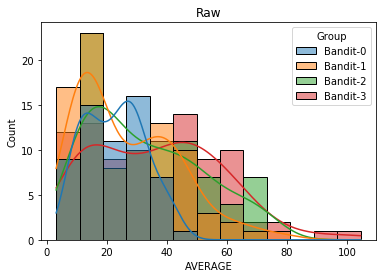

In [18]:
hist(df_raw, 'Raw')

The above plot shows the raw data, before any preprocessing. It's good to star at the raw data and understand it before we really make it as the way we want. 

- So they do not looks like Gaussians, but more like a mixture of two absolute Gaussians. 
- And they do have the "shift" of means and sharp STD for the last group as we imagined, that's good!
- It is even more interesting to look at the two modes of each round seperately. The modes with high AVERAGE increases along rounds; the modes with low AVERAGE are almost the same for each round, where the Bandit-3 has a much smaller count. Again, that's because we chose to use a smaller exploration rate. 

In the following, we show approach A., that is only apply mean shift by reference AVERAGE in each round. 

          Round       Rep1       Rep2       Rep3       Rep4       Rep5  \
Group                                                                    
Bandit-0      0  61.642593  54.000150  70.723901  52.988498  53.098672   
Bandit-1      1  53.353770  48.429490  46.984807  59.342834  61.586414   
Bandit-2      2  59.943767  59.097223  57.707680  61.202654  56.345406   
Bandit-3      3  61.483603  56.800350  56.577781        NaN        NaN   

               Rep6    AVERAGE       STD  Pred Mean  Pred Std  Pred UCB  
Group                                                                    
Bandit-0  50.024592  57.079734  8.606778        NaN       NaN       NaN  
Bandit-1  58.746524  54.740640  8.073239   0.809026   0.65549  2.120007  
Bandit-2  53.619776  57.986084  6.996816        NaN       NaN       NaN  
Bandit-3        NaN  58.287244  5.439408        NaN       NaN       NaN  


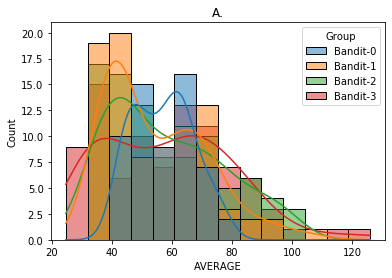

In [24]:
path_a = folder_path + 'Results_Microplate_partialTrue_normTrue_None_roundRep_formatSeq_logFalse_Round4_RNFalse.csv'

df_a = pd.read_csv(path_a)

hist(df_a, 'A.')

Ok, now let's have a look at how normalisation changes the distributions. More importantly, whether those changes accord to out goal?

          Round      Rep1      Rep2      Rep3      Rep4      Rep5      Rep6  \
Group                                                                         
Bandit-0      0 -0.163209 -0.189951 -0.261227 -0.244961 -0.127663 -0.326687   
Bandit-1      1 -0.022714 -0.025198 -0.031339 -0.021758 -0.020465 -0.025127   
Bandit-2      2 -0.056235 -0.055903 -0.051396 -0.052778 -0.063579 -0.052342   
Bandit-3      3 -0.045771 -0.052833 -0.048403       NaN       NaN       NaN   

           AVERAGE       STD  Pred Mean  Pred Std  Pred UCB  
Group                                                        
Bandit-0 -0.218950  0.328302        NaN       NaN       NaN  
Bandit-1 -0.024433  0.289695   0.809026   0.65549  2.120007  
Bandit-2 -0.055372  0.282409        NaN       NaN       NaN  
Bandit-3 -0.049002  0.222647        NaN       NaN       NaN  


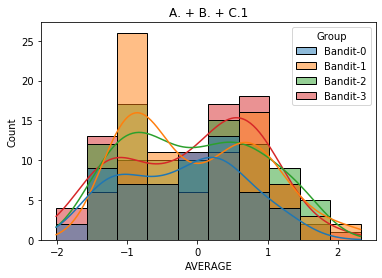

In [25]:
hist(df_normalised, 'A. + B. + C.1')

The above plot is A+ B+ C.1, i.e. z-score normalisation over rounds. 
Now TIRs are still two-mode Gaussians, but with zerom-mean and unit-variance (well, not exactly, since we actually perform normalisation for each replicates). They lose the pattern of Gaussian mean shifts and STD changes. 

          Round      Rep1      Rep2      Rep3      Rep4      Rep5      Rep6  \
Group                                                                         
Bandit-0      0  0.091067 -0.007355  0.418875 -0.221390 -0.151049 -0.279551   
Bandit-1      1 -0.462563 -0.409288 -0.721135  0.006004  0.174725  0.162022   
Bandit-2      2 -0.010704  0.088041 -0.241328  0.037852 -0.126374 -0.143150   
Bandit-3      3 -0.096561 -0.049585 -0.330439       NaN       NaN       NaN   

           AVERAGE       STD  Pred Mean  Pred Std  Pred UCB  
Group                                                        
Bandit-0 -0.024901  0.338447        NaN       NaN       NaN  
Bandit-1 -0.208373  0.528104   0.809026   0.65549  2.120007  
Bandit-2 -0.065944  0.416298        NaN       NaN       NaN  
Bandit-3 -0.158862  0.357052        NaN       NaN       NaN  


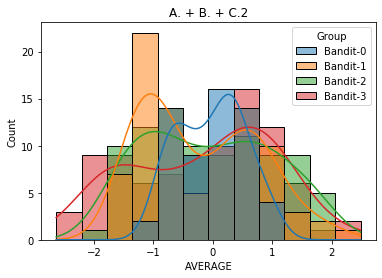

In [26]:
hist(df_RNF, 'A. + B. + C.2')

How about min-max normalsiation? 

          Round      Rep1      Rep2      Rep3  Rep4  Rep5  Rep6   AVERAGE  \
Group                                                                       
Bandit-0      0  0.541772  0.506016  0.617782   NaN   NaN   NaN  0.555190   
Bandit-1      1  0.440136  0.432632  0.384565   NaN   NaN   NaN  0.419111   
Bandit-2      2  0.523089  0.523433  0.482721   NaN   NaN   NaN  0.509748   
Bandit-3      3  0.507327  0.498306  0.464491   NaN   NaN   NaN  0.490041   

               STD  Pred Mean  Pred Std  Pred UCB  
Group                                              
Bandit-0  0.069338        NaN       NaN       NaN  
Bandit-1  0.059904   0.809026   0.65549  2.120007  
Bandit-2  0.074400        NaN       NaN       NaN  
Bandit-3  0.060252        NaN       NaN       NaN  


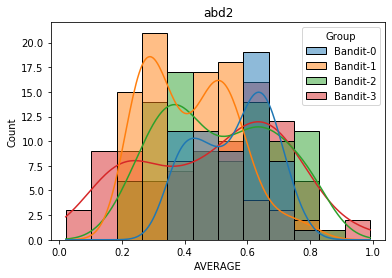

In [28]:
path_abd2 = folder_path + 'Results_Microplate_partialTrue_normTrue_minmax_roundRep_formatSeq_logTrue_Round4_RNFalse.csv'

df_abd2 = pd.read_csv(path_abd2)

hist(df_abd2, 'abd2')

          Round      Rep1      Rep2      Rep3  Rep4  Rep5  Rep6   AVERAGE  \
Group                                                                       
Bandit-0      0  0.358184  0.311695  0.430292   NaN   NaN   NaN  0.366723   
Bandit-1      1  0.277232  0.256469  0.213708   NaN   NaN   NaN  0.249136   
Bandit-2      2  0.341592  0.362225  0.311538   NaN   NaN   NaN  0.338452   
Bandit-3      3  0.356631  0.339455  0.301229   NaN   NaN   NaN  0.332438   

               STD  Pred Mean  Pred Std  Pred UCB  
Group                                              
Bandit-0  0.070662        NaN       NaN       NaN  
Bandit-1  0.050730   0.809026   0.65549  2.120007  
Bandit-2  0.068072        NaN       NaN       NaN  
Bandit-3  0.053428        NaN       NaN       NaN  


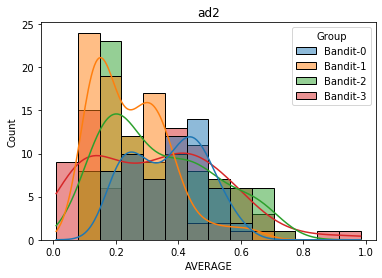

In [30]:
path_ad2 = folder_path + 'Results_Microplate_partialTrue_normTrue_minmax_roundRep_formatSeq_logFalse_Round4_RNFalse.csv'

df_ad2 = pd.read_csv(path_ad2)

hist(df_ad2, 'ad2')

The above plot is for A+B+C.2, i.e. z-score normalisation over all the data. 
You might also spot that Bandit-3 has a wider spread compared with other groups, for both tiles. The reason is that Bandit-3 used to have a smaller STD, to achieve a unit variance, Bandit-3 needs to spread wider than other groups. 


## Doubts:


So I think my question is actually, how to normalise when data is skewed?

Wait, I am now confused, why do we want to do z-score normalisation at all, GP seems to have no assumption for labels: for each x, it assumes y is Gaussian distributed. But is there also a Gaussian assumption for all labels for different x? So if it is true, then we do not need to do the overall normalisation at all, but actually, we should try to normalise replicates for each data point, so that they are all under the same Gaussian noise distribution. 

# Prediction

Now we show the prediction with raw data and the above two kinds of normalisation strategies. 

In [6]:
# copy from the pipeline for recommending round 2 seq

rec_size = 90
l = 6
s = 1
beta = 0
alpha = 2
sigma_0 = 1
kernel_name = 'WD_Kernel_Shift'
embedding = 'label'
kernel_norm_flag = True
centering_flag = True
unit_norm_flag = True

In [7]:
def pred(df):

    train_df = df[df['Round']!= 3]
    test_df = df[df['Round'] == 3]

    # train on train_df and test on test_df

    top_n = Top_n_ucb(
        train_df, kernel_name=kernel_name, l=l, s=s, sigma_0=sigma_0,
        embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta, 
        kernel_norm_flag=kernel_norm_flag, 
        centering_flag = centering_flag,    
        unit_norm_flag=unit_norm_flag,
        df_design= test_df)

    top_n.prediction()

    # write prediction to df_design
    # AVERAGE: true TIR; pred mean/std: predictions
    df_design = top_n.df_design

    
    spearman_cor = spearmanr(np.asarray(df_design['AVERAGE']), np.asarray(df_design['pred mean']))
    print('spearman cor: ', spearman_cor)

    # df_design_sorted_ave = df_raw.sort_values('pred mean', ascending=False).head(10)
    # spearmanr(np.asarray(df_design_sorted_ave['AVERAGE']), np.asarray(df_design_sorted_ave['pred mean']))
    threshold = 1.0
    xlims = [test_df['AVERAGE'].min(), test_df['AVERAGE'].max()]
    ylims = [df_design['pred mean'].min(), df_design['pred mean'].max()]
    # xlims = [-2, 2]
    # ylims = [0.5, 1.3]

    cmap = sns.cubehelix_palette(as_cmap=True)

    plt.scatter(test_df['AVERAGE'], df_design['pred mean'], c = df_design['pred std'], cmap = cmap)
    plt.fill_between([xlims[0], threshold], y1 = [threshold], y2= [ylims[-1]], color = 'r', alpha = 0.05)
    plt.fill_between([threshold, xlims[1]], y1 = [ylims[0]], y2= [threshold], color = 'r', alpha = 0.05)
    plt.fill_between([xlims[0], threshold], y1 = [ylims[0]], y2= [threshold], color = 'g', alpha = 0.05)
    plt.fill_between([threshold, xlims[-1]], y1 = [threshold], y2= [ylims[1]], color = 'g', alpha = 0.05)
    plt.colorbar()
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel('AVERAGE TIR')
    plt.ylabel('Pred TIR')
    plt.title('Round 3 Prediction')
    plt.plot(xlims, [threshold, threshold], color = 'orange')
    plt.plot([threshold, threshold],ylims, color = 'orange')

/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_design['RBS6'] = df_design['RBS'].str[7:13]
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

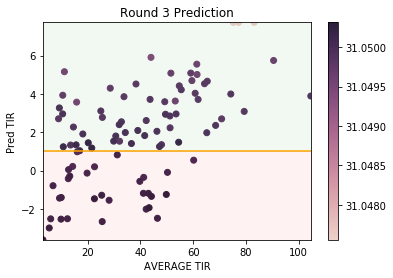

In [8]:
pred(df_raw)

/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_design['RBS6'] = df_design['RBS'].str[7:13]
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

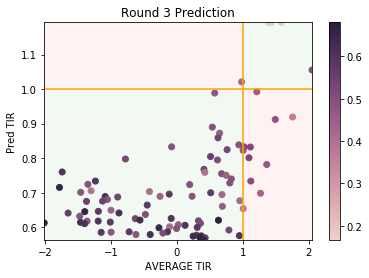

In [9]:
pred(df_normalised)

/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_design['RBS6'] = df_design['RBS'].str[7:13]
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

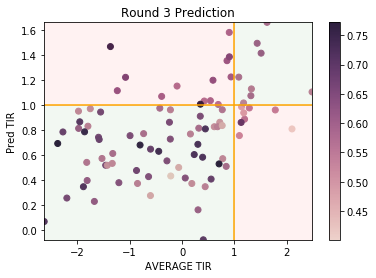

In [10]:
pred(df_RNF)

/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_design['RBS6'] = df_design['RBS'].str[7:13]
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

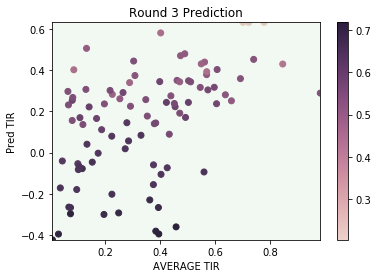

In [31]:
pred(df_ad2)